In [2]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from transformations_pose2homo import apply_transformation
from ranges_and_cartesian import cart2pol, normalise_angles, read_scans_write_points

v_pol = np.vectorize(cart2pol)
v_norm = np.vectorize(normalise_angles)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
def self_matmul(matrix, vectors):
    vectors_transformed = np.copy(vectors)

    for i in range(vectors_transformed.shape[0]):
        vector = vectors_transformed[i, :]
        vectors_transformed[i, :] = apply_transformation(matrix, vector)

In [ ]:
# load points and poses from file

# get the poses as homogeneous transformations corresponding to the two range scans
poses_as_transform = np.load('data/poses_as_transforms.npz')
HT_C1 = poses_as_transform['HT_C1']
HT_C2 = poses_as_transform['HT_C2']

# load the two laser scans. they are already in a 4x1 format
points_from_ranges = np.load('data_add/points_from_self_sim_ranges.npz')
points_p1_4x1 = points_from_ranges['points_p1']
points_p2_4x1 = points_from_ranges['points_p2']

# extended = np.load("data/extended_points.npz")
# points_p1 = extended["points_p1_extended"]
# points_p2 = extended["points_p2_extended"]

In [ ]:
# eyeballed this transformation. It roughly corresponds to -60 degree rotation arouns z-axis
my_trans = np.eye(4)
alpha = -59.5 * (np.pi / 180)
c = np.cos(alpha) # 0.5
s = np.sin(alpha) # -0.8660254
my_trans[0:2, 0:2] = np.array([[c, -s],     # rotation around the z-axis
                               [s, c]])
my_trans[0, 3] = -0.7       # translation in x
my_trans[1, 3] = 0.25        # translation in y
print(my_trans)

# making a slightly far away transformation for the ICP to find the original
beta = -55 * (np.pi / 180)
cos_a = np.cos(beta)
sin_a = np.sin(beta)
ft = 0.01

fake_trans = np.eye(4)
fake_trans[0:2, 0:2] = np.array([[cos_a, -sin_a], 
                                 [sin_a, cos_a]])
fake_trans[0, 3] = -0.7 - ft
fake_trans[1, 3] = 0.3 + ft

In [ ]:
# points_test = np.matmul(points_p1_4x1, my_trans.T)
plt.figure()
plt.scatter(points_p1_4x1[:, 0], points_p1_4x1[:, 1], s = 6, label="self simulated")
plt.scatter(points_p2_4x1[:, 0], points_p2_4x1[:, 1], s = 6, label="target points")
# plt.scatter(points_test[:, 0], points_test[:, 1], s = 6, label="transformed points")

plt.grid(True)
plt.legend()
plt.show()

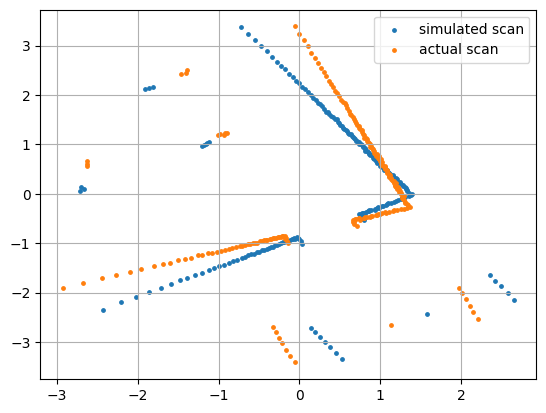

In [4]:
# load the two laser scans. they are already in a 4x1 format
dspoints_from_ranges = np.load('data_add/confirming_large_distance.npz')
dspoints_p1_4x1 = dspoints_from_ranges['points_p1']
dspoints_p2_4x1 = dspoints_from_ranges['points_p2']

plt.figure()
plt.scatter(dspoints_p1_4x1[:, 0], dspoints_p1_4x1[:, 1], s = 6, label="simulated scan")
plt.scatter(dspoints_p2_4x1[:, 0], dspoints_p2_4x1[:, 1], s = 6, label="actual scan")

plt.grid(True)
plt.legend()
plt.show()

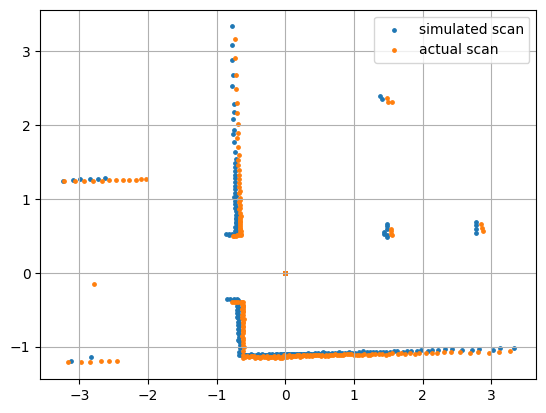

In [2]:
# load the two laser scans. they are already in a 4x1 format
dspoints_from_ranges = np.load('data/points_from_sim_ranges.npz')
dspoints_p1_4x1 = dspoints_from_ranges['points_p1']
dspoints_p2_4x1 = dspoints_from_ranges['points_p2']

plt.figure()
plt.scatter(dspoints_p1_4x1[:, 0], dspoints_p1_4x1[:, 1], s = 6, label="simulated scan")
plt.scatter(dspoints_p2_4x1[:, 0], dspoints_p2_4x1[:, 1], s = 6, label="actual scan")

plt.grid(True)
plt.legend()
plt.show()

Count 1:  150
Count 2:  149


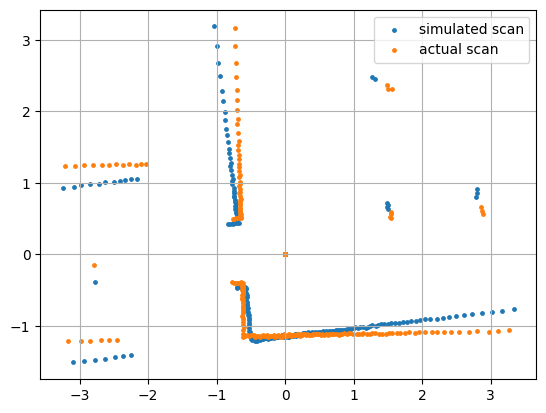

In [2]:
readFile = "data_add/different_scans.dat"
saveFile = 'data_add/points_diff_scans.npz'

read_scans_write_points(readFile, saveFile)
# load the two laser scans. they are already in a 4x1 format
diff_points_from_ranges = np.load(saveFile)
dspoints_p1_4x1 = diff_points_from_ranges['points_p1']
dspoints_p2_4x1 = diff_points_from_ranges['points_p2']

plt.figure()
plt.scatter(dspoints_p1_4x1[:, 0], dspoints_p1_4x1[:, 1], s = 6, label="simulated scan")
plt.scatter(dspoints_p2_4x1[:, 0], dspoints_p2_4x1[:, 1], s = 6, label="actual scan")

plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# create a point cloud object for open3d and input your points in there
source_pcd = o3d.geometry.PointCloud()
target_pcd = o3d.geometry.PointCloud()

source_pcd.points = o3d.utility.Vector3dVector(points_p1_4x1[:, 0:3])
target_pcd.points = o3d.utility.Vector3dVector(points_p2_4x1[:, 0:3])

threshold = 0.02*1e1

In [ ]:
# do icp and get the resulting transformation. then transform points according to new transformation

# performing the ICP with open3d
reg_p2p = o3d.pipelines.registration.registration_icp(
    source_pcd, target_pcd, threshold, fake_trans,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1000))

# the final trasnformation as a 4x4 hom. trans.
T_icp = reg_p2p.transformation

# manually multiply matric and vector because there are inf values that need to be dealt with
points_p1_icp = np.matmul(points_p1_4x1, T_icp.T)

print(reg_p2p)
print("Transformation is:")
print(T_icp)
# draw_registration_result(source_pcd, target_pcd, reg_p2p.transformation)

In [ ]:


# for i in range(points_p1_icp.shape[0]):
#     vector = points_p1_icp[i, :]
#     points_p1_icp[i, :] = apply_transformation(T_icp, vector)

In [ ]:
# how well did the transformed values match the target
plt.figure()
plt.scatter(points_p1_4x1[:, 0], points_p1_4x1[:, 1], s = 6, label="source points")
plt.scatter(points_p2_4x1[:, 0], points_p2_4x1[:, 1], s = 6, label="target points")
plt.scatter(points_p1_icp[:, 0], points_p1_icp[:, 1], s = 6, label="source after ICP")

plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# some book-keepping. converting back to polar coordinates, removing duplicates, etc.

# based on new points transformed by ICP find the ranges and angles
ranges_icp_t, angles_icp_t = v_pol(points_p1_icp[:, 0], points_p1_icp[:, 1])

# based on old target points find the ranges and angles
target_ranges, target_angles = v_pol(points_p2_4x1[:, 0], points_p2_4x1[:, 1])

# normalise all angles between 0 and 2pi
angles_icp_normed = v_norm(angles_icp_t)
target_angles_normed = v_norm(target_angles)

# stack the ranges and normalised angles next to each other in the same array
transformed_scan = np.column_stack((ranges_icp_t, angles_icp_normed))
target_scan = np.column_stack((target_ranges, target_angles_normed))

# sort both arrays based on the angles, i.e. 2nd column of the array
transScan_sorted = transformed_scan[transformed_scan[:, 1].argsort()]
targetScan_sorted = target_scan[target_scan[:, 1].argsort()]

# find the indices where unique angle values exist in the original array
# this is because the interpolate function does not want duplicate values in domain of the function
_, indx = np.unique(targetScan_sorted[:, 1], return_index=True)
targetScan_sortUnique = targetScan_sorted[indx, :]

In [ ]:
# just to check how removing the duplicate values did
plt.figure()
# plt.scatter(targetScan_sorted[:, 1], targetScan_sorted[:, 0], s=8, label="orig")
plt.scatter(targetScan_sortUnique[:, 1], targetScan_sortUnique[:, 0], s=6, label="unique")
plt.scatter(transScan_sorted[:, 1], transScan_sorted[:, 0], s=6, label="trans")

plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# create a function that can interpolate based on cubic spline interpolation
func_scans = interp1d(targetScan_sortUnique[:, 1], targetScan_sortUnique[:, 0], kind='cubic', bounds_error=True, assume_sorted=True)

# evaluate function at the angles from the ICP transformed points
# these ranges should closely match the ranges from the target scan
interp_ranges_trans = func_scans(transScan_sorted[:, 1])

In [ ]:
# see how the target scan, transformed scan, and the interpolated values look

plt.figure(figsize=(16, 9))
plt.scatter(targetScan_sortUnique[:, 1], targetScan_sortUnique[:, 0], s=10, label="original")
plt.scatter(transScan_sorted[:, 1], transScan_sorted[:, 0], s=10, label="trans")
plt.scatter(transScan_sorted[:, 1], interp_ranges_trans, s=6, label="interp")

plt.grid(True)
plt.legend()
plt.show()